In [1]:
! pip install tensorflow-datasets

In [25]:
# Params here
IMG_SIZE = 160

BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

BASE_LEARNING_RATE= 0.0001

EPOCHS = 2

In [3]:
import os 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


print(f'Tensorflow version is {tf.__version__}')
print(f'Tensorflow dataset version is {tfds.__version__}')

Tensorflow version is 2.6.0
Tensorflow dataset version is 4.0.1


# Load data from Tensorflow Datasets

In [4]:
data, metadata = tfds.load(
    'cats_vs_dogs',
    # split = [
    #     tfds.Split.TRAIN.subsplit(tfds.percent[:85]), # Training dataset 80%,
    #     tfds.Split.TRAIN.subsplit(tfds.percent[85:90]), # Validation dataset 5%
    #     tfds.Split.TRAIN.subsplit(tfds.percent[90:]) # Test dataset
    # ]
    split=['train[:85%]', 'train[85%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0E4AOX/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
(raw_train, raw_validation, raw_test) = data

In [6]:
raw_train 
# 長濶大細不一，未pre-process

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

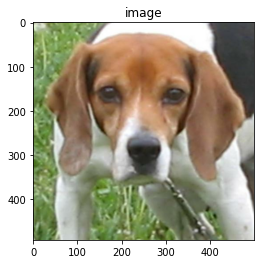

In [7]:
for image,label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title('image')

In [8]:
image,label = next(iter(raw_train.take(1)))

plt.figure()
plt.imshow(image)
plt.title('Original image')



# 呢個function 係超級重要，通常一個Neural Network，佢都有預到你嘅input dimenson 係點嘅
def resize_image(image,label):
    image = tf.cast(image,tf.float32)
    image = image / 127.5  - 1
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

image,label = resize_image(image,label)

plt.figure()
plt.imshow(image)
plt.title('After image')

Text(0.5, 1.0, 'After image')

In [9]:
train = raw_train.map(resize_image)
validation = raw_validation.map(resize_image)
test = raw_test.map(resize_image)

In [10]:


train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
for image_batch,label_batch in train_batches.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 160, 160, 3)
(32,)


# Load Pre-trained Model
We need to load Google MobileNetV2 from Tensorflow

In [12]:

IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False)
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 1280)


# Add two layers to classify cats and dogs

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_average_batch = global_average_layer(feature_batch)
print(global_average_batch)

tf.Tensor(
[[0.03261168 0.         0.02382294 ... 0.         1.1332545  0.27281594]
 [0.31895426 0.5412743  0.1826165  ... 0.31277758 0.         0.28892514]
 [0.5091234  0.0294333  0.55457705 ... 0.9080806  1.003363   0.7434314 ]
 ...
 [0.         0.         0.25300738 ... 0.14806733 0.         0.        ]
 [0.2549915  0.         0.22184849 ... 0.20217234 0.03137022 0.08140848]
 [0.12057495 0.         0.14531046 ... 0.         0.         2.9895315 ]], shape=(32, 1280), dtype=float32)


In [28]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(global_average_batch)
print(prediction_batch)

tf.Tensor(
[[ 0.12907368]
 [ 0.5867168 ]
 [ 0.22913548]
 [-0.44712785]
 [ 0.38879403]
 [-1.7876966 ]
 [-0.81826246]
 [-0.18772636]
 [ 0.4387659 ]
 [-0.33172387]
 [-0.6520423 ]
 [-1.0990365 ]
 [ 1.5994169 ]
 [-1.3237064 ]
 [ 1.1287662 ]
 [ 0.9517382 ]
 [ 0.960961  ]
 [ 0.8772479 ]
 [-0.71806705]
 [ 0.5322895 ]
 [-0.8514128 ]
 [ 0.35697505]
 [ 0.3916497 ]
 [-0.64339066]
 [ 1.5056527 ]
 [-0.21771374]
 [-1.1254975 ]
 [ 0.6216658 ]
 [-1.2918915 ]
 [-1.1397563 ]
 [-1.3789784 ]
 [ 0.60644484]], shape=(32, 1), dtype=float32)


In [29]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:

validation_steps = 20

validation_loss, validation_accuracy = model.evaluate(validation_batches,steps=validation_steps)

print(validation_loss)
print(validation_accuracy)

20/20 [==============================] - 4s 68ms/step - loss: 0.0875 - accuracy: 0.9625
0.08745262026786804
0.9624999761581421


In [31]:
history = model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Epoch 1/2
618/618 [==============================] - 81s 123ms/step - loss: 0.2437 - accuracy: 0.8950 - val_loss: 0.1134 - val_accuracy: 0.9613
Epoch 2/2
618/618 [==============================] - 75s 119ms/step - loss: 0.0897 - accuracy: 0.9707 - val_loss: 0.0778 - val_accuracy: 0.9682


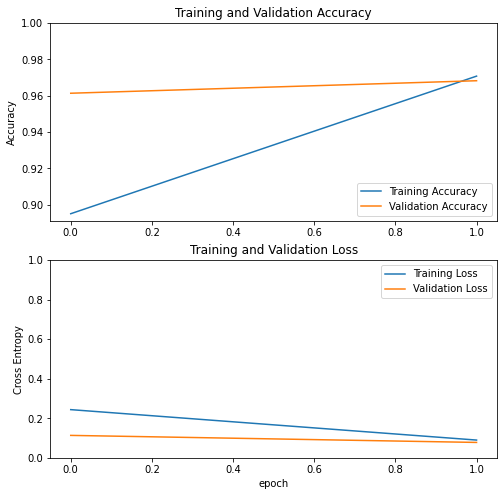

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
image, label = next(iter(test.take(1)))
image,label  = resize_image(image,label)
image_batch = tf.convert_to_tensor(np.array([image]))
prediction = model(image_batch)

In [41]:
prediction

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.26377952]], dtype=float32)>

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


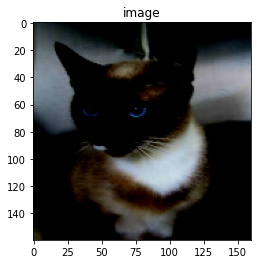

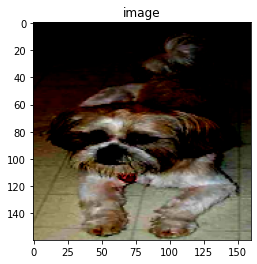

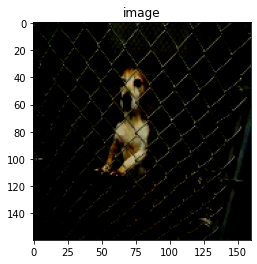

In [51]:
for image,label in test.take(10):
  plt.figure()
  plt.imshow(image)
  plt.title('image')
  # 1 張圖嘅batch
  image_batch = tf.convert_to_tensor(np.array([image]))
  prediction = tf.math.round(tf.nn.sigmoid(model(image_batch)))
  print(prediction)



In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

model.save('/content/gdrive/My Drive/cats_vs_dogs',overwrite=True);

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/cats_vs_dogs/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/cats_vs_dogs/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
